In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15109 MiB, 15109 MiB, 0 MiB


In [ ]:
!pip -q install -U tensorflow_addons > log   # update tfa in case students need to use it

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # We load it before tf. Still useless?  https://github.com/tensorflow/tensorflow/issues/38197
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten, Activation ,Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, RNN, LSTM, TimeDistributed
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)


CPU times: user 3.04 s, sys: 491 ms, total: 3.53 s
Wall time: 3.86 s


In [ ]:
from google.colab import files
uploder1 = files.upload()

Saving tXY.csv to tXY.csv


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id');
tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.2017,0.2022,0.2015,0.2017,447,0.2020
1,72,0.2025,0.2028,0.2023,0.2024,592,0.2024
2,63,0.2019,0.2021,0.2017,0.2021,470,0.2020
3,77,0.2016,0.2020,0.2012,0.2019,515,0.2015
4,77,0.2016,0.2019,0.2007,0.2010,682,0.2012
...,...,...,...,...,...,...,...
499995,2704,1.1549,1.1769,1.1482,1.1543,2858,1.1543
499996,2108,1.1605,1.1784,1.1509,1.1561,2522,1.1578
499997,2580,1.1485,1.1665,1.1396,1.1453,2635,1.1481


In [ ]:
from google.colab import files
uploder2=files.upload()
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

Saving sampleSubmission.csv to sampleSubmission.csv


id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

In [ ]:
def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return tf.abs(r_num / r_den)

In [ ]:
# Приведение значений к диапазону от 0 до 1
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
#scale_taX=scale.fit_transform(tXY[['Open','High','Low','Close']])
txy_scale=tXY.copy()
#txy_scale[['Open','High','Low','Close']]=scale_taX
#Создание новой фичи - разность по сравнению с предыдущим target
txy_scale['Delta']=txy_scale['Close']-txy_scale.shift(periods=1, fill_value=0)['Close']
txy_scale['Delta'].values[0]=0
#New_Feature - log_diff
txy_scale['Log_Diff'] = [0]*len(txy_scale)
txy_scale['Log_Diff'][1:]=np.diff(np.log(txy_scale['Close'].values))

txy_scale

<ipython-input-24-973718f83c45>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txy_scale['Log_Diff'][1:]=np.diff(np.log(txy_scale['Close'].values))


,Count,Open,High,Low,Close,Volume,VWAP,Delta,Log_Diff
id,,,,,,,,,
0,64,0.2017,0.2022,0.2015,0.2017,447,0.2020,0.0000,0.000000
1,72,0.2025,0.2028,0.2023,0.2024,592,0.2024,0.0007,0.003464
2,63,0.2019,0.2021,0.2017,0.2021,470,0.2020,-0.0003,-0.001483
3,77,0.2016,0.2020,0.2012,0.2019,515,0.2015,-0.0002,-0.000990
4,77,0.2016,0.2019,0.2007,0.2010,682,0.2012,-0.0009,-0.004468
...,...,...,...,...,...,...,...,...,...
499995,2704,1.1549,1.1769,1.1482,1.1543,2858,1.1543,0.0003,0.000260
499996,2108,1.1605,1.1784,1.1509,1.1561,2522,1.1578,0.0018,0.001558
499997,2580,1.1485,1.1665,1.1396,1.1453,2635,1.1481,-0.0108,-0.009386


**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md). 

taX.shape=(K,Nx,p)=(300, 20000, 9); taY=(K,Ny)=(300, 24431)


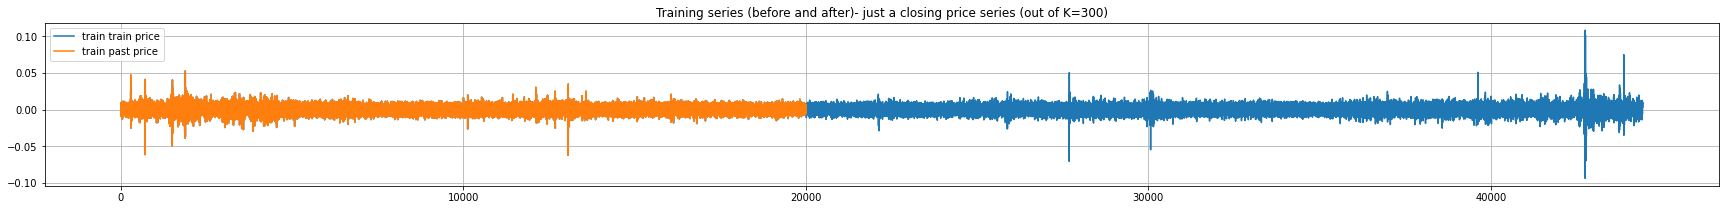

In [ ]:
K, (N, p), Nx, Ny = 300, tXY.shape, 20000, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(txy_scale.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(txy_scale.loc[i:(i+Ny-1),'Log_Diff'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,-1], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,-1], columns=['train past price']).plot(grid=True, ax=ax);

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [ ]:
%%time
p=9
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can
print(p)
m = Sequential(
  [LSTM(100, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init), 
  Dropout(.2, name='d1'),
  BatchNormalization(),
  LSTM(100, name='LSTM2', kernel_initializer=Init, recurrent_initializer=Init),
  Dropout(.2, name='d2'),
  Dense(Ny, name='out', kernel_initializer=Init) ], name='RNN_model') # we build Ny forecasts
m.summary()
m.compile(optimizer='adam', loss='mean_squared_error')
hist = m.fit(taX,taY, epochs=20, batch_size=32)

9
Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 100)         44000     
                                                                 
 d1 (Dropout)                (None, None, 100)         0         
                                                                 
 batch_normalization_8 (Batc  (None, None, 100)        400       
 hNormalization)                                                 
                                                                 
 LSTM2 (LSTM)                (None, 100)               80400     
                                                                 
 d2 (Dropout)                (None, 100)               0         
                                                                 
 out (Dense)                 (None, 24431)             2467531   
                                                       

The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

In [ ]:
tX_recent = txy_scale.iloc[-Nx:,:]  # most recent history of the coin


tX_recent.shape=(Nx,p)=(20000, 9)
1/1 [==============================] - 2s 2s/step


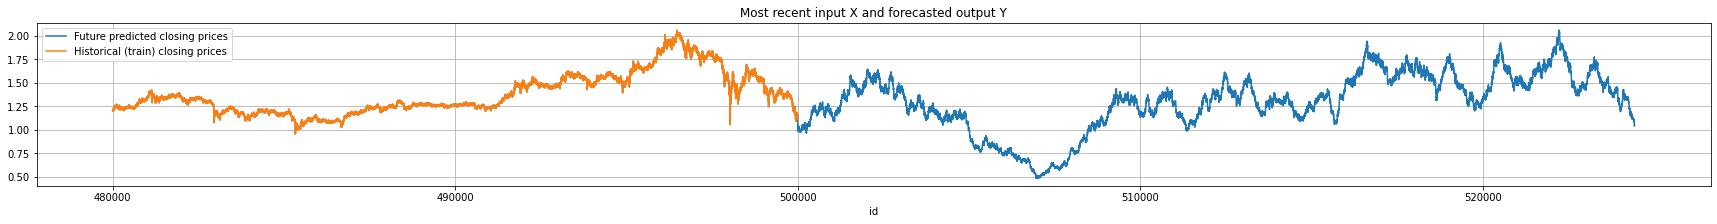

In [ ]:
tX_recent = txy_scale.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
temp=pd.DataFrame(columns=txy_scale.columns,index=pY.index)
temp['Log_diff'] = m.predict(tX_recent.values[np.newaxis,...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
temp['Close']=np.exp(temp['Log_diff'].values.cumsum())
#temp[['Open','High','Low','Close']]=scale.inverse_transform(temp[['Open','High','Low','Close']])
pY['Close']=temp['Close']
ax = pd.concat([tXY.iloc[-Nx:,:].Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tXY.iloc[-Nx:,:].Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left). 
1. You can download the generated CSV file and submit it to Kaggle.

In [ ]:
ToCSV(pY, 'Crypto-baseline')

# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 896 sec > 300 sec limit!!!


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend